# Capstone Project: Eye For Blind

## Problem statement

Imagine a condition where you are not able to see and enjoy the images, a problem that blind people face on a daily basis.

In this project, we have to understand how a blind person can overcome all these problems and go along with ordinary people when it comes to seeing. 

The model shall convert the contents of an image and will give the output in the form of audio.

In this project, you have to convert the image to text description first and then using a simple text to speech API, the extracted text description/caption shall be converted to audio. So the central part of this capstone is focused on building the caption/text description as the second part, which is transforming the text to speech is relatively easy with the text to speech API. 

![Description%20Image.jpg](attachment:Description%20Image.jpg)

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by the CNN-based encoder, and this will be decoded by an RNN model.

The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.paper.https://arxiv.org/abs/1502.03044

The data set is taken from the Kaggle website and consists of a sentence-based image description having a list of 8,000 images that are each paired with five different captions, which provide clear descriptions of the salient entities and events of the image. https://www.kaggle.com/adityajn105/flickr8k

Once the model is built, we shall deploy the project on your local system using a Flask based model to generate audio-based content for any image.

In [1]:
# Install wordcloud - A data visualization technique used for representing text data in which the size of each word
# indicates its frequency or importance
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Install gTTS: Google Text-to-Speech - a Python library and CLI tool to interface with Google Translate's 
# text-to-speech API.
!pip install gTTs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Install playsound - a cross platform module that can play audio files
!pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=40c38381b16c7826e7bc3e369d59c0ed6dd65ca9efdd409476157d763b14f6c2
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [4]:
#Import all the required libraries

# Library to work with arrays and algebra
import numpy as np 

# Library for data analysis
import pandas as pd

# Data visualization and graphical plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# retrieve files/pathnames matching a specified pattern
import glob

from skimage import io
pd.set_option('display.max_colwidth',-1)

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Mount the google drive content to load the dataset to google colab

In [5]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 1. Import the dataset and Read the Images and Captions in to respective variables

In [6]:
# Read the dataset into dataset_Images variable
dataset_Images = '/content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images'
dataset_Captions = '/content/gdrive/MyDrive/EyeForBlind/Flickr8K/captions.txt'

# Read all the images into imgs variable
imgs = glob.glob(dataset_Images + '/*.jpg',recursive=True)

# Read all the images into imgs variable
captions = glob.glob(dataset_Captions + '/*.txt',recursive=True)

# Display the total no.of images in the dataset
print("The total images present in the dataset: {}".format(len(imgs)))

# Display the total no.of captions in the dataset
print("The total captions present in the dataset: {}".format(len(captions)))

The total images present in the dataset: 8091
The total captions present in the dataset: 0


### 2. Visualise both the images and captions present in the dataset

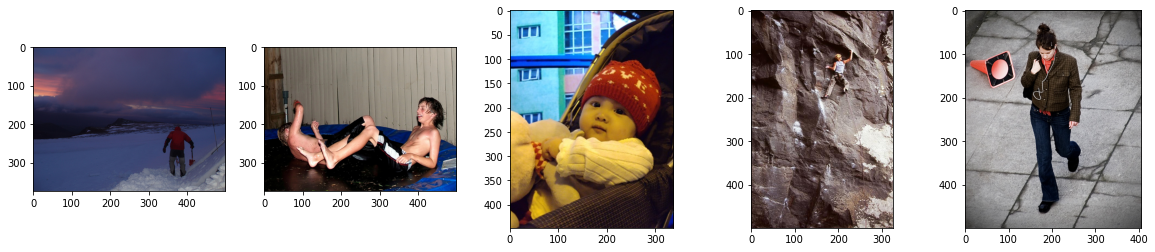

In [7]:
# Display the first 5 images:
Display_Images= imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

### 3. Create indexes and map from word-to-index and index-to-word.

In [8]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):  
    text=open(filename).read()
    return text

text_file = '/content/gdrive/MyDrive/EyeForBlind/Flickr8K/captions.txt'

doc = load_doc(text_file)

# print the captions alongside the images name 
print(doc[:600], "........")

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7 ........


### 4. Define a data frame to summarize Image ID, Image path and Image captions

In [9]:
image_path='/content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/'

# Store Image ID
all_img_id=[]
# Store Image path
all_img_vector=[] 
# Store Image captions
annotations= []

with open('/content/gdrive/MyDrive/EyeForBlind/Flickr8K/captions.txt', 'r') as fo:
    # skip the heading 
    next(fo) 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        
        # Strip at new line and and stop.
        annotations.append(split_arr[1].rstrip('\n.'))
        all_img_vector.append(image_path+split_arr[0])
        
# Dataframe to summarizes the image_ID, image_path and image_captions
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['Image_ID','Image_Path', 'Image_Captions']) 
    
df

Image_ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450  997722733_0cb5439472.jpg    
40451  997722733_0cb5439472.jpg    
40452  997722733_0cb5439472.jpg    
40453  997722733_0cb5439472.jpg    
40454  997722733_0cb5439472.jpg    

                                                                          Image_Path  \
0      /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                                                                              ...   
40450  /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/997722733_0cb5439472.jpg    
40451  /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/997722733_0cb5439472.jpg    
40452  /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/997722733_0cb5439472.jpg    
40453  /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/997722733_0cb5439472.jpg    
40454  /content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/997722733_0cb5439472.jpg    

                                                                   Image_Captions  
0      A child in a pink dress is climbing up a set of stairs in an entry way      
1      A girl going into a wooden building                                         
2      A little girl climbing into a wooden playhouse                              
3      A little girl climbing the stairs to her playhouse                          
4      A little girl in a pink dress going into a wooden cabin                     
...                                                         ...                    
40450  A man in a pink shirt climbs a rock face                                    
40451  A man is rock climbing high in the air                                      
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453  A rock climber in a red shirt                                               
40454  A rock climber practices on a rock climbing wall                            

[40455 rows x 3 columns]

#### Inference:

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [10]:
# Get the type of annotations in the dataset
print("The type of annotations in the dataset: {}".format(type(annotations)))

The type of annotations in the dataset: <class 'list'>


In [11]:
# Get the number of images/annotations in the given data set
print("The total annotations present in the dataset: {}".format(len(annotations)))

The total annotations present in the dataset: 40455


### 5. Understand the vocabulary in the data set

In [12]:
# Extract the vocabulary from the annotations and display them
vocabulary = [word for line in annotations for word in line.split()]
vocabulary

['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'Two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'towa

#### Inference:

We can see that some vocabulary words are in smaller case while some are in upper case, like 'a' and 'A'

It is better to have all the vocabulary in same case - small case

In [13]:
# Read the vocabulary 
vocabulary = [word.lower() for line in annotations for word in line.split()]

val_count = collections.Counter(vocabulary)

In [14]:
# Get the value count of all the vocabulary
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

### 6. Visualise the top 30 occuring words in the captions


 The top 30 words with the frequency count:
a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996

 The top 30 most occuring words: 



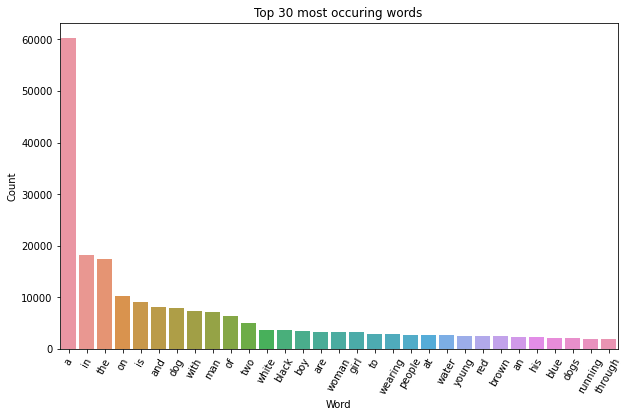

In [15]:
# Get the first 30 most occuring words 
print("\n The top 30 words with the frequency count:")
for word, count in val_count.most_common(30):
    print(word, ": ", count)

print("\n The top 30 most occuring words: \n")
# function to get more occuring words
def fn_top_words_on_count(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    plt.title("Top 30 most occuring words")
    plt.xlabel("Word")
    plt.ylabel("Count")
    
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation = 60)
    
    plt.show()

#write your code here
fn_top_words_on_count(val_count,30)

### 7. Visualise the Images

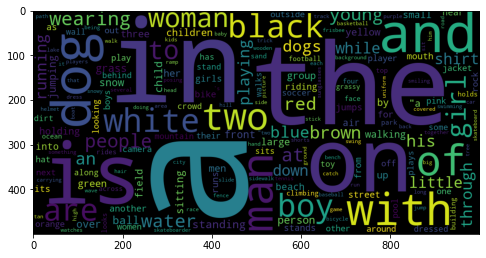

In [16]:
# Use WordCloud to get the frequency of STOPWORDS 
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

#### Inference:

It is evident from the image that the STOPWORDS are having higher frequency.

We will find the top 30 commom words excluding the STOPWORDS.


The top 30 most occuring words excluding the STOPWORDS and their frequency of occurance:
dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735
standing :  1702
ball :  1678
grass :  1565
person :  1515
child :  1507
snow :  1439
jumping :  1430
front :  1322
sitting :  1322
small :  1257

 Dictionary without the STOPWORDS:

 Plotting without the STOPWORDS:


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

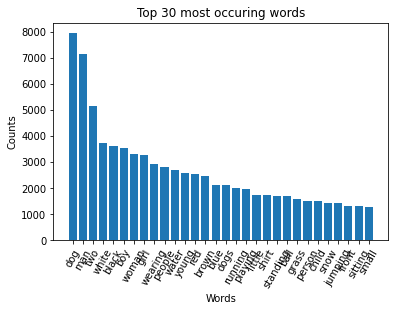

In [17]:
# Get the first 30 most occuring words excluding the STOPWORDS
print("\nThe top 30 most occuring words excluding the STOPWORDS and their frequency of occurance:")
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)
print("\n Dictionary without the STOPWORDS:")
# function to get more occuring words excluding the STOPWORDS
dict_without_stopwords = {}

for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count

print("\n Plotting without the STOPWORDS:")
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))

plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation = 60)

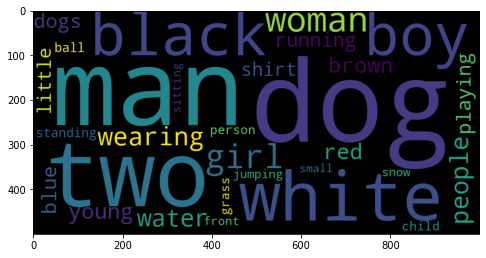

In [18]:
# Use WordCloud to get the frequent words after excluding the STOPWORDS
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

### 8. Visualise the captions

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


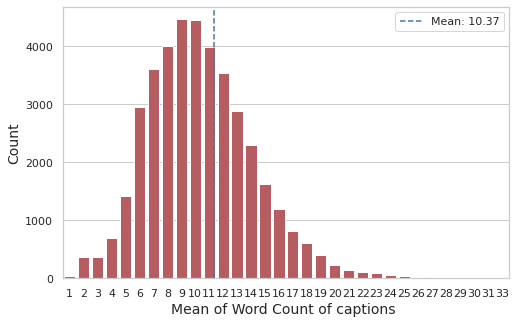

In [19]:
caption_df=df.copy()
caption_df['caption_word_count'] = caption_df["Image_Captions"].str.split().str.len()

mean = sum(caption_df['caption_word_count'])/len(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)

plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color = "r")

plt.xlabel('Mean of Word Count of captions ', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

ax.axvline(mean, color = 'b', linestyle = '--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


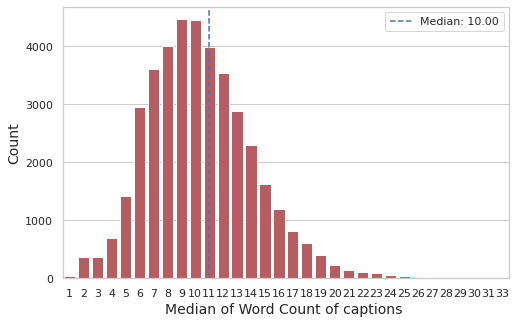

In [20]:
mean = np.median(caption_df['caption_word_count'])

sns.set(style = "whitegrid", font_scale = 1)
plt.figure(figsize = (8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")

plt.xlabel('Median of Word Count of captions ', fontsize=14)
plt.ylabel('Count', fontsize = 14)

ax.axvline(mean, color='b', linestyle = '--')
plt.legend({'Median: {:.2f}'.format(mean): mean})

#### Inference:
It is evident that the captions mostly are of length 10 to 11 words

### 9. Visualise the Images and captions together

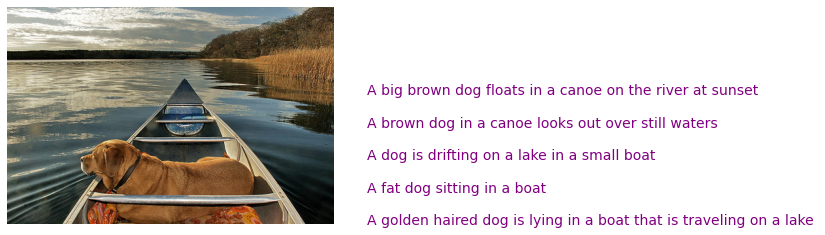

In [21]:
# Visualise image with caption 
def caption_and_image(image_id,frame):
    # get captions
    caps=("\n"*2).join(frame[frame['Image_ID']==image_id].Image_Captions.to_list())
    
    fig, ax = plt.subplots()
    ax.set_axis_off()
    
    idx=df.Image_ID.to_list().index(image_id)
    im=Image.open(df.Image_Path.iloc[idx])
    
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize = 14,color='purple')
# Visualise an image(random)   
caption_and_image(df.Image_ID.iloc[4044],df)

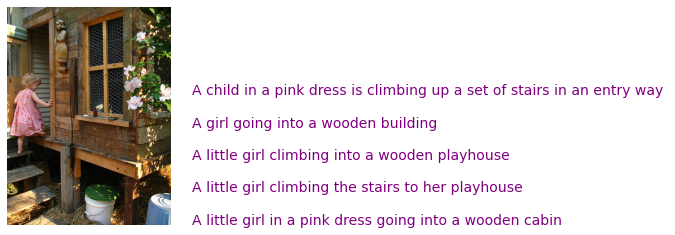

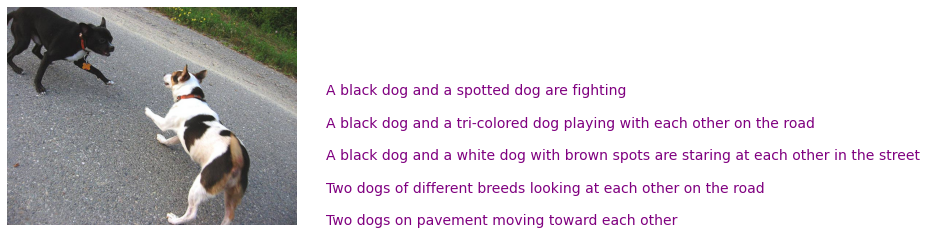

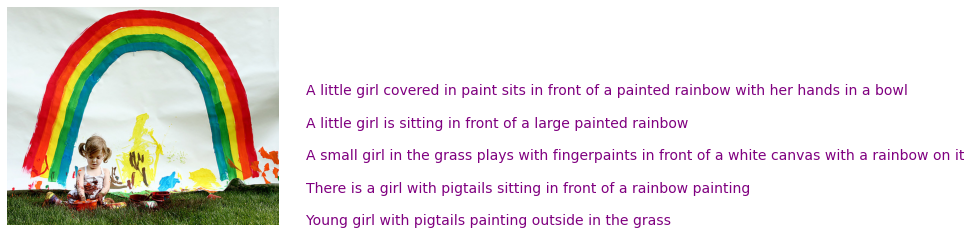

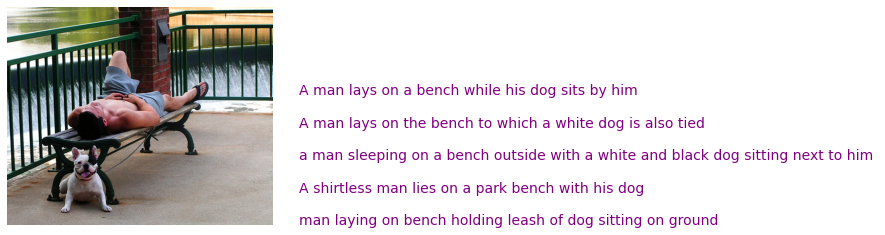

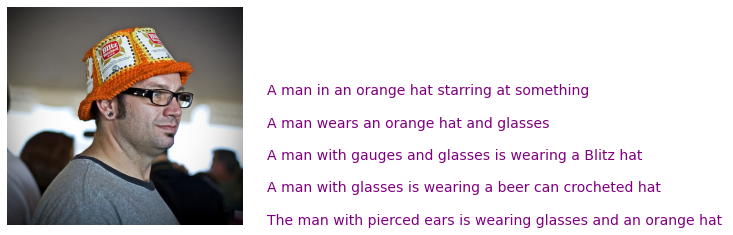

In [22]:
# Visualise Images with caption with in a given range
def plot_caption_and_image(start,end,frame):
    for i in range(start,end):
        caption_and_image(frame.Image_ID.drop_duplicates().iloc[i],frame)
        
plot_caption_and_image(0,5,df)

### 10. Data Cleaning

- 1. Convert all the words to lower case
- 2. Remove the punctuations
- 3. Retain only the words, remove the numbers
- 4. We are not removing STOPWORDS, but we will remove the hanging 's' ,'a' or any one letter word.
- 5. No stemming is performed on the words. 

In [23]:
# Remove punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)

for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    # lower case
    line = [word.lower() for word in line] 
    # remove punctuation from each token
    line = [word.translate(remove_punctuation) for word in line]
    # remove the hanging 's' and 'a'
    line = [word for word in line if len(word)>1] 
    # remove the tokens with numbers within them
    line = [word for word in line if word.isalpha()]
    # Store as strings
    annotations[i] =  ' '.join(line)

In [24]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [25]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

### 11. Pre-Process the captions
- 1. Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 

- 2. Keep the total vocaublary to top 5,000 words     for saving memory.

- 3. Replace all other words with the unknown token "UNK" .
- 4. Create word-to-index and index-to-word mappings.
- 5. Pad all sequences to be the same length as the longest one.

In [26]:
# create the tokenizer
top_voc = 5000
tokenizer = Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")

# Update internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(annotations) 

# Transform each text to a sequence of integers.
train_seqs = tokenizer.texts_to_sequences(annotations)

# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# Create word-to-index and index-to-word mappings.
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [27]:
# Check the tokenizer
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [28]:
# Tokenizer words
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [29]:
# Tokenizer words with their count
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [30]:
# Annotations of the first 5 images
annotations[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [31]:
# Training sequences of the first 5 images
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [32]:
# Get no. of images and type of the sequence
print(len(train_seqs))
print(type(train_seqs))

40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


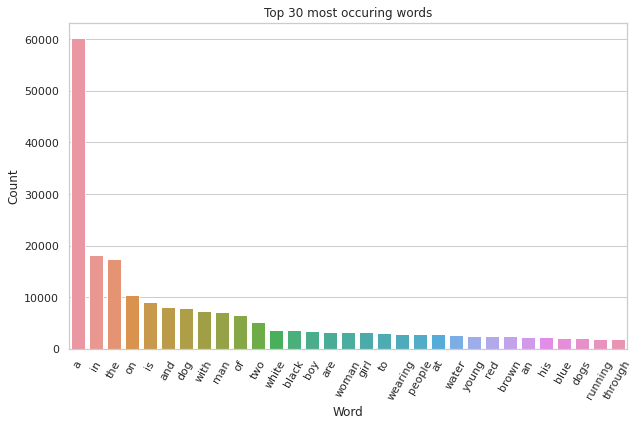

In [33]:
# Create a word count of your tokenizer to visulize the top 30 occuring words after text processing
tokenizer_top_words = [word for line in annotations for word in line.split()]

tokenizer_top_words_count = collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

# function to get more occuring words
fn_top_words_on_count(val_count,30)

In [34]:
# wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)

# plt.figure(figsize=(8,8))
# plt.imshow(wordcloud_token)
# plt.grid(b=None)

In [35]:
def fn_min_max_for_nested_array(nested_array):
    array = [len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l = fn_min_max_for_nested_array(train_seqs)

In [36]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding = 'post',maxlen = max_l)
         
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


#### Inference:

- 1. We are padding zero at last using padding='post'. 
- 2. We know that start token acts as prompter and it expect some word after tat.
- 3. Zero indicates no word and have no value at beginning.So,in order to not 
      disturb the existing sequence structure we pad at end. 
- 4. This padding will cause problem while creating embedding vector.
- 5. So we will be applying mask then.

### 11. Pre-process the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [37]:
# check to know about image format as we will be setting data format as none 
# in tf.keras.applications.inception_v3.preprocess_input
tf.keras.backend.image_data_format() 

'channels_last'

#### Inference:

Image data format have default as 'channels_last' which indicates Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

In [38]:
Image_Shape = (299, 299)

In [39]:
# Let's see how preprocessed image looks by preprocessing first 5 images
preprocessed_img=[]

for img in imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    # img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.decode_jpeg(img,channels=0)
    img = tf.image.resize(img, Image_Shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


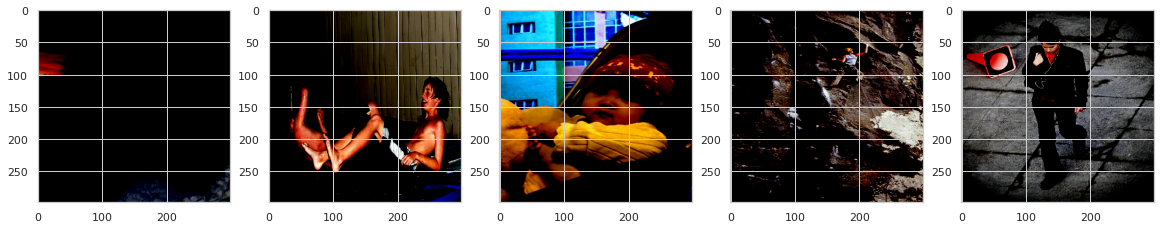

In [40]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

Let's write a function for preprocessing and return images and it's path so that we can use concept of vectorization and preprocess images paralleley rather than writing for loop

In [41]:
# vectorization and preprocess images
def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    # Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, Image_Shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

### 12. Create train and test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 

  Create the train-test spliit using 80-20 ratio & random state = 42

2. Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [42]:
#write your code here
# mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [43]:
New_Image_Data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [44]:
# performing the train-test spliit using 80-20 ratio & random state = 42
img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,
                                                                                        cap_vector,
                                                                                        test_size = 0.2,
                                                                                        random_state = 42)

In [45]:
print("Training data for images: " + str(len(img_train_data)))
print("Testing data for images: " + str(len(img_test_data)))
print("Training data for Captions: " + str(len(caption_train_data)))
print("Testing data for Captions: " + str(len(caption_test_data)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


### 13. Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



**Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.**


In [46]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer


87924736/87910968 [==============================] - 1s 0us/step


In [47]:
# Extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

#### Inference:
We are not classifying the images here. 

We are only extracting an vector for our images.

Hence we are removing the softmax layer from the model.

In [48]:
# Extract features from each image in the dataset
image_features_dict={}

# using tqdm as progress bar
for image, image_path in tqdm(New_Image_Data): 
    
    # feeding images from above created dataset to Inception v3 which we build above
    features_for_batch = image_features_extract_model(image) 
    
    # We are sqeezing/squashing
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3]))  
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()



100%|██████████| 127/127 [02:33<00:00,  1.21s/it]


In [49]:
# features_for_batch

In [50]:
# features_for_batch_flattened

In [51]:
batch_feat.shape

TensorShape([64, 2048])

Print  dictionaries of first 5 elememts

In [52]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items 

[('/content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16988818],
         [0.        , 0.        , 1.0106202 , ..., 0.        , 0.        ,
          0.06110416],
         ...,
         [0.        , 0.        , 2.037989  , ..., 1.2033163 , 0.        ,
          1.9922264 ],
         [0.        , 0.        , 0.9047285 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2529362 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/content/gdrive/MyDrive/EyeForBlind/Flickr8K/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.664062  , 0.46306533, ..., 0.        , 0.        ,
          3.332647  ],
         [0.        , 1.227077  , 0.        , ..., 0.        , 0.25423333,
          3.329993  ],
         [1.288106

In [53]:
# Give both images and captions as input to the model
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [54]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, so it doesn't attempt to shuffle the entire sequence in memory. 
# Instead, it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

# Tried with different batch sizes. Kernel is dieing for 32. So batch size is set to 64.
BATCH_SIZE = 64 

def data_generator(images_data, captions_data):
    
    # Create a dataset using from_tensor_slices
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # AUTOTUNE is used to set the no. of parallel calls dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [55]:
train_dataset = data_generator(img_train_data,caption_train_data) 
test_dataset = data_generator(img_test_data,caption_test_data) 

In [56]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 31)


### 14. Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [57]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE 
test_num_steps = len(img_test_data) // BATCH_SIZE 
max_length = 31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### 14 a. Encoder

In [58]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        
        # build your Dense layer with relu activation, It acts as the fully connected layer
        self.dense = tf.keras.layers.Dense(embed_dim) 
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features) 
        
        # appl RELU activation
        features = tf.keras.activations.relu(features, alpha = 0.01, max_value = None, threshold = 0)  
        return features

In [59]:
encoder=Encoder(embedding_dim)

### 14 b. Attention model

In [60]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        # build a Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build a Dense layer
        self.W2 = tf.keras.layers.Dense(units) 
        # build a final Dense layer with unit 1
        self.V  = tf.keras.layers.Dense(1)
        self.units = units
    # features shape: (batch_size, 8*8, embedding_dim)
    # hidden shape: (batch_size, hidden_size)
    def call(self, features, hidden):
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis] 
        
        # build your score funciton to shape: (batch_size, 8*8, units)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)
        
        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
        
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # the tensor is reduced along the second dimension (columns)
        return context_vector, attention_weights


- 1. The Attention model does a linear transformation of the input.

- 2. Apply tanh function to do non linear transformation and to produce smooth output .

- 3. The features produced from dense layer/FC layer of encoder and hidden state of decoder are passed to tanh function
     and the attention score is calculated

- 4. As the output must be in range (0,1), Apply softmax function on the obtained attention score which now gives the atttention weights. 

- 5. Compute the weighted sum of the attention weights on the feature vector and then derived our context vector.

- 6. The context vector produced are adaptive as they change for each and every time stamp. 

### 14 c. Decoder

In [61]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        
        # iniitalise Attention model with units
        self.attention = Attention_model(self.units)
        
        # build Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        
        # build Dense layer
        self.d1 = tf.keras.layers.Dense(self.units) 
        
        # build Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)

    def call(self,x,features, hidden):
        # create context vector and attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # embed input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        
        # Concatenate input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        
        # Extract the output and hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed) 
        output = self.d1(output)
        
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

- 1. We know that the encoder output along with hidden state is passed to attention model.
- 2. The attention model produces context vector.
- 3. This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.
- 4. After passing the GRU output to dense layers,
- 5. Finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

In [62]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [63]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)

#(batch, 8*8, embed_dim)
print('Feature shape from Encoder: {}'.format(features.shape))
#(batch,vocab_size)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
 #(batch, 8*8, embed_dim)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## 15. Model training and optimization
1. Set the optimizer and  loss object

2. Create your checkpoint path

3. Create your training & testing step functions

4. Create your loss function for the test dataset

In [64]:
# define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)

# define your loss object - crossentropy SparseCategoricalCrossentropy - It calculates loss between the labels and predictions.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
# zero causes discrepency. Mask zero to false
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # Get the ideal shape
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [66]:
checkpoint_path = "Flickr8K/checkpoint1"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [67]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [68]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        # write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
            # passing encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            
            loss += loss_function(target[:, t], predictions)

            dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    # compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

In [69]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    # hidden = decoder.reset_state(batch_size = target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # Record operations for automatic differentiation.
    with tf.GradientTape() as tape: 
        # write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
            # pass encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:, t], predictions) 

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)
    
    # calaculate average loss for every batch
    avg_loss = (loss / int(target.shape[1]))

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    # calaculate gradients wrt every trainable variable
    grads = tape.gradient(loss, tot_trainables_variables) 

    # compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

- 1. As the training converges faster, we use teacher forcing
- 2. In the initial steps of training, the predictions of the model are very bad. If we do not use teacher forcing, the hidden states of the model might be   
     updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep 
     on adding, and the model will learn wrongly and perform badly at the end.
- 3. So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the 
     next input to the decoder

In [70]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [71]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.441, & test loss is 1.202
Time taken for 1 epoch 169.68793725967407 sec

Test loss has been reduced from 100.000 to 1.202


 13%|█▎        | 2/15 [03:56<23:38, 109.13s/it]

For epoch: 2, the train loss is 1.111, & test loss is 1.059
Time taken for 1 epoch 66.44353938102722 sec

Test loss has been reduced from 1.202 to 1.059


 20%|██        | 3/15 [05:03<17:56, 89.69s/it] 

For epoch: 3, the train loss is 1.007, & test loss is 0.972
Time taken for 1 epoch 66.41864585876465 sec

Test loss has been reduced from 1.059 to 0.972


 27%|██▋       | 4/15 [06:09<14:46, 80.58s/it]

For epoch: 4, the train loss is 0.932, & test loss is 0.906
Time taken for 1 epoch 66.47319006919861 sec

Test loss has been reduced from 0.972 to 0.906


 33%|███▎      | 5/15 [07:16<12:35, 75.55s/it]

For epoch: 5, the train loss is 0.871, & test loss is 0.848
Time taken for 1 epoch 66.49022603034973 sec

Test loss has been reduced from 0.906 to 0.848


 40%|████      | 6/15 [08:22<10:52, 72.52s/it]

For epoch: 6, the train loss is 0.819, & test loss is 0.798
Time taken for 1 epoch 66.49336290359497 sec

Test loss has been reduced from 0.848 to 0.798


 47%|████▋     | 7/15 [09:29<09:24, 70.59s/it]

For epoch: 7, the train loss is 0.770, & test loss is 0.750
Time taken for 1 epoch 66.49026703834534 sec

Test loss has been reduced from 0.798 to 0.750


 53%|█████▎    | 8/15 [10:36<08:05, 69.33s/it]

For epoch: 8, the train loss is 0.726, & test loss is 0.709
Time taken for 1 epoch 66.48806166648865 sec

Test loss has been reduced from 0.750 to 0.709


 60%|██████    | 9/15 [11:42<06:50, 68.48s/it]

For epoch: 9, the train loss is 0.685, & test loss is 0.666
Time taken for 1 epoch 66.45830416679382 sec

Test loss has been reduced from 0.709 to 0.666


 67%|██████▋   | 10/15 [12:49<05:39, 67.88s/it]

For epoch: 10, the train loss is 0.647, & test loss is 0.629
Time taken for 1 epoch 66.39753484725952 sec

Test loss has been reduced from 0.666 to 0.629


 73%|███████▎  | 11/15 [13:55<04:29, 67.47s/it]

For epoch: 11, the train loss is 0.612, & test loss is 0.597
Time taken for 1 epoch 66.4161205291748 sec

Test loss has been reduced from 0.629 to 0.597


 80%|████████  | 12/15 [15:02<03:21, 67.19s/it]

For epoch: 12, the train loss is 0.580, & test loss is 0.562
Time taken for 1 epoch 66.3835198879242 sec

Test loss has been reduced from 0.597 to 0.562


 87%|████████▋ | 13/15 [16:08<02:13, 66.96s/it]

For epoch: 13, the train loss is 0.549, & test loss is 0.532
Time taken for 1 epoch 66.3065414428711 sec

Test loss has been reduced from 0.562 to 0.532


 93%|█████████▎| 14/15 [17:15<01:06, 66.83s/it]

For epoch: 14, the train loss is 0.521, & test loss is 0.507
Time taken for 1 epoch 66.40089654922485 sec

Test loss has been reduced from 0.532 to 0.507


100%|██████████| 15/15 [18:21<00:00, 73.46s/it]

For epoch: 15, the train loss is 0.497, & test loss is 0.485
Time taken for 1 epoch 66.42572116851807 sec

Test loss has been reduced from 0.507 to 0.485


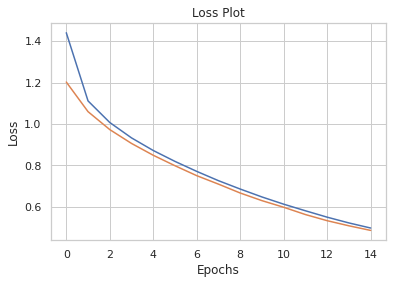

In [72]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()


## 16. Model Evaluation
1. Define your evaluation function using greedy search

2. Define your evaluation function using beam search ( optional)

3. est it on a sample data using BLEU score

### 16 a. Greedy Search

In [73]:
def greedy_evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) 
    
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id =  tf.argmax(predictions[0]).numpy()
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [74]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [75]:
from nltk.translate.bleu_score import sentence_bleu

In [76]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [77]:
img_test=img_test_data.copy()

In [78]:
# modify the given code as function to run it several times by changing weights
def predicted_caption_audio_greedy(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = greedy_evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Let's use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 34.32945239845196
Real Caption: muzzled white dog is running on the grass
Prediction Caption: white dog with blue muzzle trots through the dirt


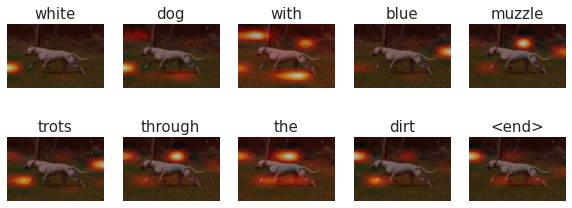

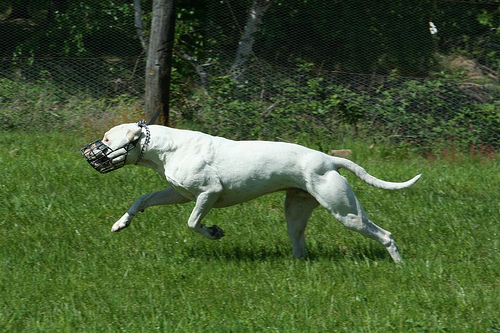

In [79]:
test_image = predicted_caption_audio_greedy(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 49.79188789046481
Real Caption: dog with floppy ears runs on the grass
Prediction Caption: white dog is running on the grass


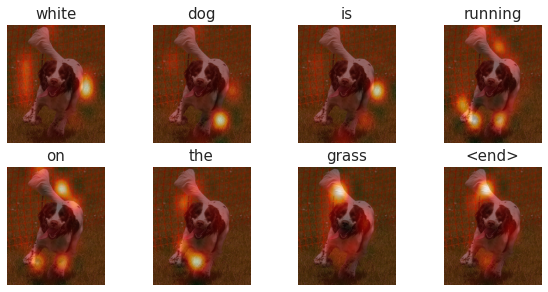

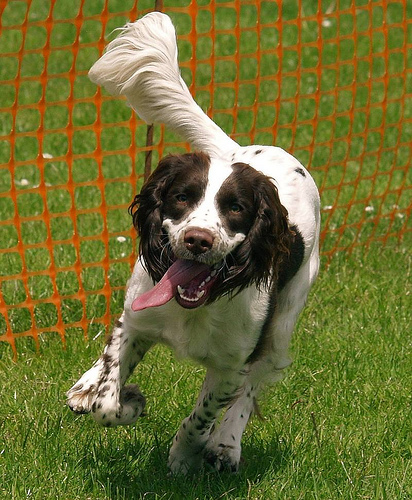

In [80]:
test_image = predicted_caption_audio_greedy(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 66.22820988780764
Real Caption: two children standing near wheelbarrow are looking at the lake in front of them
Prediction Caption: two children are standing near wheelbarrow are looking at the woods


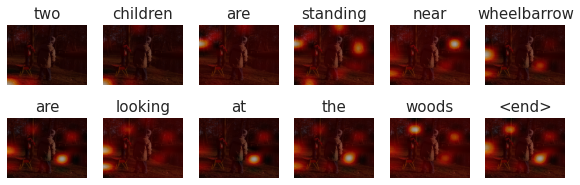

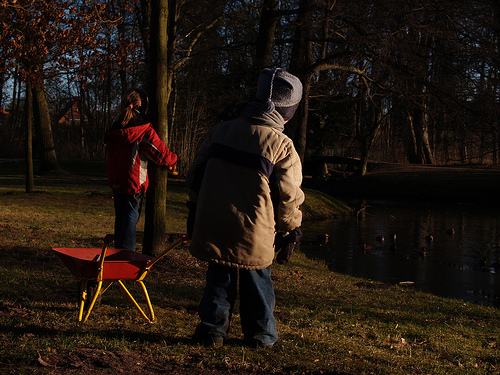

In [81]:
test_image1 = predicted_caption_audio_greedy(len(img_test),False,weights=(0.25,0.25,0,0))

Image.open(test_image1)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 2.2298491325947587e-76
Real Caption: couple practice different ways to wear sunglasses in front of red car
Prediction Caption: man with sunglasses and woman wearing sunglasses and woman wearing sunglasses and woman wearing sunglasses and woman wearing sunglasses and woman wearing sunglasses and woman wearing sunglasses and woman wearing


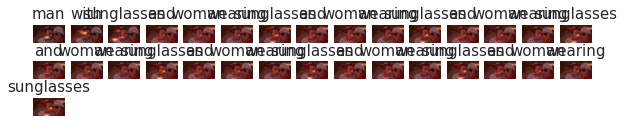

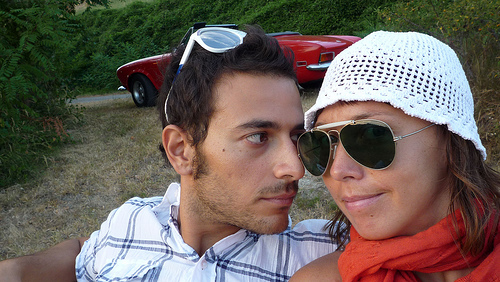

In [82]:
test_image = predicted_caption_audio_greedy(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 40.85166851999189
Real Caption: child is thrown by man in the swimming pool
Prediction Caption: father launches his daughter in the swimming pool


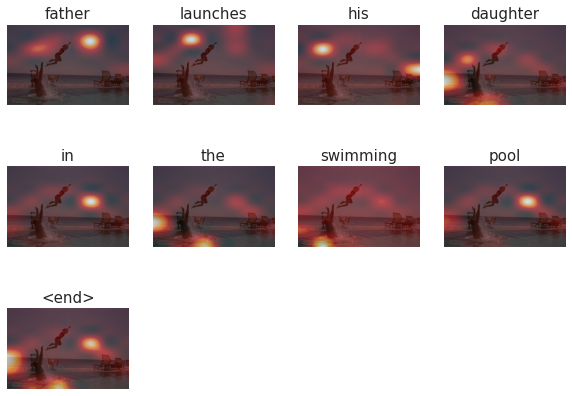

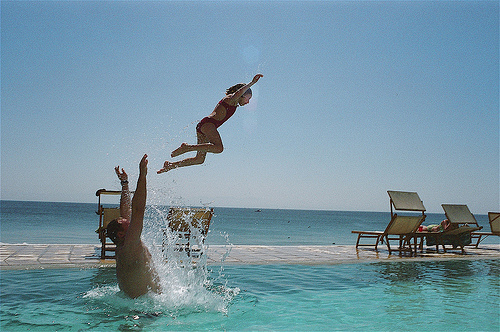

In [83]:
test_image = predicted_caption_audio_greedy(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)

## 16 b. Beam Search

In [84]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return result2, attention_plot,final_caption

In [85]:
# modify the given code as function to run it several times by changing weights
def predicted_caption_audio_beam(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):
  cap_test=caption_test_data.copy()
  rid = np.random.randint(0, random)
  test_image = img_test[rid]

  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
  result, attention_plot,pred_test = beam_evaluate(test_image)

  real_caption=filt_text(real_caption)      

  pred_caption=' '.join(result).rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()

  score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
  print(f"BELU score: {score*100}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', pred_caption)
  plot_attmap(result, attention_plot, test_image)

  #Let's use Google Text to Speech Online API from playing the predicted caption as audio
  speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
  speech.save('voice.mp3')
  audio_file = 'voice.mp3'
    
  #playsound('voice.wav')
  display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
  return test_image

In [86]:
# test_image = predicted_caption_audio_beam(5,False,weights=(0.5,0.5,0,0))

# Image.open(test_image)

# captions=beam_evaluate(test_image)
# print(pred_caption)

## Summary: 

1. Installed packages required to do the project
- a. wordcloud - data visualization technique, indicates the words frequency or importance
- b. playsound - a cross platform module that can play audio files
- c. gTTs - a Python library and CLI tool to interface with Google Translate's  text-to-speech API.
	
2. Imported the dataset from kaggle -  https://www.kaggle.com/adityajn105/flickr8k 

3. Read the Images and Captions in to seperate variable 

4. EDA is performed
	a. Understanding of the vocabulary
	
	b. Visualized top 30 most frequently occuring images
	
	c. Displayed Images, Captions and both together as well

5. Data Cleaning:
	a. converted all the words to lower case
	
	b. removed punctuations
	
	c. handled STOPWORDS
	
	d. removed numbers and retained the words                   

6. Data preprocessing
	a. Pre-Process the images:
		i. Resize them into the shape of (299, 299)
		ii. Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 
		
	a. Pre-Process the Captions:
		i. Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
        ii. Keep the total vocaublary to top 5,000 words for saving memory.
        iii. Replace all other words with the unknown token "UNK" .
        iv. Create word-to-index and index-to-word mappings.
        v. Pad all sequences to be the same length as the longest one.

7. Data preparation - The data set is splitted into train and test dataset.

8. InceptionV3 model is used - Inception v3 is a widely-used image recognition model that has been shown to attain 
    greater than 78.1% accuracy on the ImageNet dataset. 

9. Model is built with	encoder, decoder  and Attention Model
	a. We are extracting a feature vector for the images and not classifying them. Hence,  softmax layer can be 
    removed. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).
	
	b. The extracted feature vector is given as input to CNN Encoder which had a single Fully Connected layer. The 
    output from the encoder, hidden state(initialized to 0), and start token is passed as input to the decoder. 
	
	c. The decoder (RNN - GRU) attends over the image to predict the next word. 
	
	d. Attention model is used to make our decoder focus on a particular part of the image at a time rather than 
    focusing on the entire image. It reduces any noise in the image and improves accuracy.The decoder returns the 
    predicted caption and the decoder's hidden state as output.which is sent back to the model and the predictions 
    are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing 
    to decide the next input to the decoder.
	
	e. The decoder stop predicting when the model predicts the end token.
	
	f. The prediction of the words by the model is done by finding out the probabilities of that word in the 
       vocabulary.

10. The greedy search method is used in the model built:

	a. It calculates the probability of the words according to their occurrence in the vocabulary. 
	
	b. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

11. We use the BLEU score - Bilingual Evaluation Understudy as  an evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption 
